In [5]:
from src.assignment2.simulation import *
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns


In [73]:
configs = [
    WardConfig(bed_capacity=55, urgency=7, mean_arrival_time=1/14.5, 
        mean_stay_time=2.9),
    WardConfig(40, 5, 1/11, 4),
    WardConfig(30, 2, 1/8, 4.5),
    WardConfig(20, 10, 1/6.5, 1.4),
    WardConfig(20, 5, 1/5, 3.9),
    WardConfig(0, 0, 1/13, 2.2)
]

std_configs = WardsConfigurations(configs)
std_switch = {
    WardType.A: [0.0, 0.05, 0.10, 0.05, 0.80, 0.0],
    WardType.B: [0.20, 0.0, 0.50, 0.15, 0.15, 0.0],
    WardType.C: [0.30, 0.20, 0.0, 0.20, 0.30, 0.0],
    WardType.D: [0.35, 0.30, 0.05, 0.0, 0.30, 0.0],
    WardType.E: [0.20, 0.10, 0.60, 0.10, 0.0, 0.0],
    WardType.F: [0.20, 0.20, 0.20, 0.20, 0.20, 0.0]
}

def mean_exp_dist(mean_time):
    return stats.expon.rvs(scale=mean_time)

sim_config = HospitalConfiguration(std_configs, std_switch, mean_exp_dist, mean_exp_dist)
hsim = HospitalSimulation(sim_config)

In [7]:

result_withoutf = hsim.sim_multiple_without_f(100)
result_withf = hsim.simulate_occupation_and_penalty(100)

In [14]:
ward_no_f = [ward for ward in WardType if ward is not WardType.F]

no_f_penalty = result_withoutf.expected_penalty(ward_no_f)
no_f_penalty['Simulation'] = "Without F Ward"
with_f_penalty = result_withf.expected_penalty(ward_no_f)
with_f_penalty['Simulation'] = "With F Ward"
penalty = pd.concat([no_f_penalty, with_f_penalty]).reset_index()

no_f_admission = result_withoutf.expected_admissions()
no_f_admission['Simulation'] = "Without F Ward"
with_f_admission = result_withf.expected_admissions()
with_f_admission['Simulation'] = "With F Ward"
admission = pd.concat([no_f_admission, with_f_admission]).reset_index()

no_f_relocations = result_withoutf.expected_relocations()
no_f_relocations['Simulation'] = "Without F Ward"
with_f_relocations= result_withf.expected_relocations()
with_f_relocations['Simulation'] = "With F Ward"
relocations = pd.concat([no_f_relocations, with_f_relocations]).reset_index()

no_f_prob = result_withoutf.expected_probability_of_occupied(ward_no_f)
no_f_prob['Simulation'] = "Without F Ward"
with_f_prob = result_withf.expected_probability_of_occupied(ward_no_f)
with_f_prob['Simulation'] = "With F Ward"
prob = pd.concat([no_f_prob, with_f_prob]).reset_index()



/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Text(0, 0.5, 'Probability of Occupied')

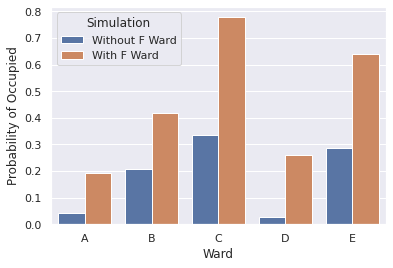

In [34]:

g = sns.barplot(data=prob, x='index', y='mean', hue='Simulation')
g.set_xlabel("Ward")
g.set_ylabel("Probability of Occupied")

In [47]:
## Example of setting bed distribution, individually and alltogether
hsim.ward_configs[WardType.A].bed_capacity = 40
hsim.ward_configs.bed_distribution = [100, 40, 10, 10, 10, 0]

## Example setting new distributions
def mean_lognorm(mean_time, k):
    s = k/mean_time**2
    mu = np.exp(np.log(mean_time) -s**2/2)
    return stats.lognorm(scale=mu, s=np.sqrt(s)).rvs()

def mean_lognorm2(mean_time):
    return mean_lognorm(mean_time, 2)

def mean_lognorm3(mean_time):
    return mean_lognorm(mean_time, 3)

def mean_lognorm4(mean_time):
    return mean_lognorm(mean_time, 4)



conf2 = HospitalConfiguration(std_configs, std_switch, mean_exp_dist, mean_lognorm2)
conf3 = HospitalConfiguration(std_configs, std_switch, mean_exp_dist, mean_lognorm3)
conf4 = HospitalConfiguration(std_configs, std_switch, mean_exp_dist, mean_lognorm4)

sim2 = HospitalSimulation(conf2)
sim3 = HospitalSimulation(conf3)
sim4 = HospitalSimulation(conf4)


In [48]:
res2 = sim2.simulate_occupation_and_penalty(5)
res3 = sim3.simulate_occupation_and_penalty(5)
res4 = sim4.simulate_occupation_and_penalty(5)

In [49]:

def combine_results(results, names):
    penalty, admission, relocations, prob = [], [], [], []
    ward_no_f = [ward for ward in WardType if ward is not WardType.F]
    for result, name in zip(results, names):
        pen = result.expected_penalty(ward_no_f)
        pen['Simulation'] = name
        penalty.append(pen)
        adm = result.expected_admissions()
        adm['Simulation'] = name
        admission.append(adm)
        rel = result.expected_relocations()
        rel['Simulation'] = name
        relocations.append(rel)
        p = result.expected_probability_of_occupied(ward_no_f)
        p['Simulation'] = name
        prob.append(p)
    return pd.concat(penalty), pd.concat(admission), pd.concat(relocations), pd.concat(prob)

ln_penalty, ln_admission, ln_relocations, ln_prob = combine_results([res2, res3, res4, result_withf], ['Log2', 'Log3', 'Log4', 'Exp'])


Text(0, 0.5, 'Penalty')

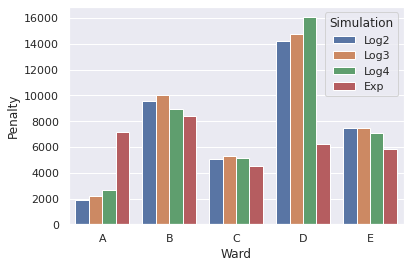

In [58]:
g = sns.barplot(data=ln_penalty.reset_index(), x='index', y='mean', hue='Simulation')
g.set_xlabel("Ward")
g.set_ylabel("Penalty")

In [75]:
def get_bed_distribution(size):
    dist = [bed / sum(std_configs.bed_distribution) for bed in std_configs.bed_distribution]
    return [b*size for b in dist]

std_configs.bed_distribution = np.round([33.33333333333333,
 24.242424242424242,
 18.181818181818183,
 12.121212121212121,
 12.121212121212121,
 0.0])
sim_low_bed = hsim.simulate_occupation_and_penalty(20)

std_configs.bed_distribution = [60.0,
 43.63636363636364,
 32.72727272727273,
 21.81818181818182,
 21.81818181818182,
 0.0]
sim_high_bed = hsim.simulate_occupation_and_penalty(20)

In [76]:
bed_penalty, bed_admission, bed_relocations, bed_prob = combine_results([sim_low_bed, result_withf, sim_high_bed], ['100 beds', '165 beds', '180 beds'])


/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simon/anaconda3/env

Text(0, 0.5, 'Expected Reloctions')

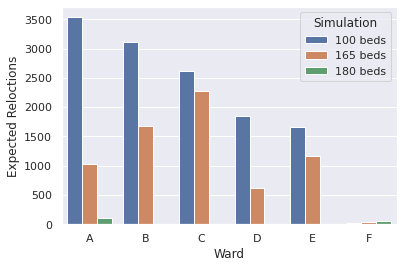

In [80]:
g = sns.barplot(data=bed_relocations.reset_index(), x='index', y='mean', hue='Simulation')
g.set_xlabel("Ward")
g.set_ylabel("Expected Reloctions")

In [74]:
get_bed_distribution(180)

[60.0,
 43.63636363636364,
 32.72727272727273,
 21.81818181818182,
 21.81818181818182,
 0.0]

In [70]:
std_configs.bed_distribution = [33.33333333333333,
 24.242424242424242,
 18.181818181818183,
 12.121212121212121,
 12.121212121212121,
 0.0]

In [72]:
np.round(std_configs.bed_distribution)

array([33., 24., 18., 12., 12.,  0.])